# NLP Challenge

In [1]:
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords

In [2]:
from collections import Counter
from keras.utils import np_utils 
#from imblearn.over_sampling import SMOTE
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer


import numpy as np
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import KFold



## Pre-Processing 

In [3]:
#import the dataframe and extract the y values.
data = pd.read_csv("/Users/jessicaparker/Downloads/challenge 4/train_reviews.csv")

X = data['review'].astype(str)
y = list((data["star"]))


X.shape

(100001,)

In [4]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords (text):
    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    return without_stopwords


def lemma(text):
    lemmatizer = WordNetLemmatizer() # Initiate lemmatizer
    lemmatized = [lemmatizer.lemmatize(word) for word in text] # Lemmatize
    lemmatized_string = " ".join(lemmatized)
    return lemmatized_string



In [5]:
X_clean = X.apply(remove_stopwords)
X_clean_2 = X_clean.apply(lemma)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_clean_2)
sequences = tokenizer.texts_to_sequences(X_clean_2)

In [7]:
x_train_pad = pad_sequences(sequences, padding='post')
# these variables are the ones that will be used from now on

In [8]:
y = np.array(y)

In [9]:
x_train_pad.shape

(100001, 600)

## Splitting and Stratifying 

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x_train_pad, y)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(x_train_pad, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_train_pad[train_index], x_train_pad[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 19578  19579  19611 ...  99998  99999 100000] TEST: [    0     1     2 ... 20598 20619 20623]
TRAIN: [     0      1      2 ...  99998  99999 100000] TEST: [19578 19579 19611 ... 40106 40110 40112]
TRAIN: [     0      1      2 ...  99998  99999 100000] TEST: [39790 39797 39816 ... 60381 60402 60409]
TRAIN: [     0      1      2 ...  99998  99999 100000] TEST: [59851 59855 59856 ... 80307 80308 80319]
TRAIN: [    0     1     2 ... 80307 80308 80319] TEST: [ 79875  79882  79885 ...  99998  99999 100000]


## Creating Categories for the Target 

You cannot performed a StratifiedKFold on your target after using a method to categorize it, so...

In [11]:
Counter(y_train), Counter (y_test)

(Counter({1.0: 11668, 5.0: 35495, 4.0: 17682, 3.0: 8776, 2.0: 6380}),
 Counter({5.0: 8873, 4.0: 4421, 1.0: 2917, 2.0: 1595, 3.0: 2194}))

In [12]:
X_train.shape
vocab_size = len(tokenizer.word_index)
vocab_size

75639

In [13]:
X_train.shape


(80001, 600)

In [14]:
y_train.shape

(80001,)

In [15]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

## Building the LSTM Model 

In [16]:
X_train.shape

(80001, 600)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, Flatten

def build_model_rnn():
    
    model = Sequential()
    
    model.add(Embedding(input_dim = 80_001, output_dim = 20, mask_zero = True))
    model.add(LSTM(10))
    model.add(Dropout(0.5, noise_shape = None, seed = None))
    
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.5, noise_shape = None, seed = None))
              
    model.add(Dense(6, activation = "softmax"))
    
    model.compile(loss ="categorical_crossentropy" , optimizer = 'adam', metrics = ["accuracy"])
    
    return model
    

In [18]:
from keras.callbacks import EarlyStopping 

es=EarlyStopping(monitor="val_loss",verbose=3,patience = 7)

In [19]:
rnn_model = build_model_rnn()

history = rnn_model.fit(X_train, y_train, batch_size=32, 
                        epochs=100, verbose=1, validation_split=0.3, callbacks = [es])

Epoch 1/100
1750/1750 [==============================] - 371s 212ms/step - loss: 1.1169 - accuracy: 0.5437 - val_loss: 0.9625 - val_accuracy: 0.5966
Epoch 2/100
1750/1750 [==============================] - 409s 234ms/step - loss: 0.8936 - accuracy: 0.6221 - val_loss: 0.8952 - val_accuracy: 0.6280
Epoch 3/100
1750/1750 [==============================] - 387s 221ms/step - loss: 0.8006 - accuracy: 0.6637 - val_loss: 0.8989 - val_accuracy: 0.6252
Epoch 4/100
1750/1750 [==============================] - 393s 225ms/step - loss: 0.7252 - accuracy: 0.6967 - val_loss: 0.9360 - val_accuracy: 0.6361
Epoch 5/100
1750/1750 [==============================] - 411s 235ms/step - loss: 0.6721 - accuracy: 0.7224 - val_loss: 0.9630 - val_accuracy: 0.6214
Epoch 6/100
1750/1750 [==============================] - 397s 227ms/step - loss: 0.6173 - accuracy: 0.7514 - val_loss: 1.0248 - val_accuracy: 0.5956
Epoch 7/100
1750/1750 [==============================] - 372s 213ms/step - loss: 0.5751 - accuracy: 0.7706

In [20]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    

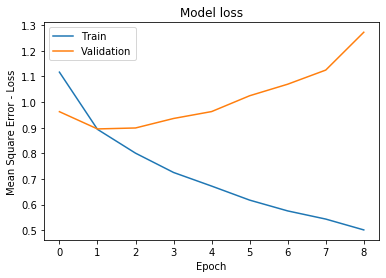

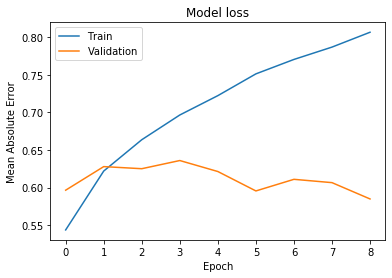

In [21]:
plot_loss(history)

## Although this model posseses a high accuracy rate, it also shows extreme overfitting. The model should be adjusted or another form of modeling should be used. 